## Code and implementation heavily borrowed, with thanks, from https://github.com/scrapfishies/russian-troll-tweets-nlp

In [41]:
import scattertext as st
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
from nltk.corpus import words, stopwords, wordnet
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation, PCA

# corex
from corextopic import corextopic as ct

In [95]:
# Dataset provided by Ben (thanks Ben!), downloaded using twint (thanks Monica and Emma for finding and teaching us about this great tool!)
df = pd.read_csv(r'C:\users\j\downloads\schoolshootingHashtag.csv')

In [92]:
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1360682756297027584,1360682756297027584,2021-02-13 12:10:24 PST,2021-02-13,12:10:24,-800,1047877570740543489,k12ssdb,K-12 School Shooting Database,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1360681612757749761,1360681612757749761,2021-02-13 12:05:51 PST,2021-02-13,12:05:51,-800,1047877570740543489,k12ssdb,K-12 School Shooting Database,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1360679965650345984,1360679965650345984,2021-02-13 11:59:18 PST,2021-02-13,11:59:18,-800,1047877570740543489,k12ssdb,K-12 School Shooting Database,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1360679060263686145,1360679060263686145,2021-02-13 11:55:42 PST,2021-02-13,11:55:42,-800,1047877570740543489,k12ssdb,K-12 School Shooting Database,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1360339122540453890,1360334012917682177,2021-02-12 13:24:55 PST,2021-02-12,13:24:55,-800,59015205,mrsgreenberg,Ryann Greenberg 🇺🇸,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'SenRickScott', 'name': 'Rick...",NaN,NaN,NaN,NaN


In [9]:
'''
Functions for preprocessing Tweets
'''

import emoji
import re
import string


def remove_url(text):
    just_text = re.sub(r"http\S+", '', text, flags=re.MULTILINE)
    return just_text


def get_hashtags(text):
    hashtags = re.findall(r"\B#\w*[a-zA-Z]+\w*", text, flags=re.MULTILINE)
    clean_hashtags = [word.replace("#", "") for word in hashtags]
    return clean_hashtags


def remove_hashtags(text):
    clean_text = re.sub(r"\B#\w*[a-zA-Z]+\w*", "", text, flags=re.MULTILINE)
    return clean_text


def remove_rt_prefix(text):
    clean_text = re.sub(r"RT @\w*[a-zA-Z]+\w*:", "", text, flags=re.MULTILINE)
    return clean_text


def make_alphanumeric(text):
    clean_text = re.sub(r"\w*\d\w*", " ", text)
    return clean_text


def remove_punc(text):
    clean_text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    return clean_text


### Dealing with Emojis ###

def get_emojis(text):
    emoji_list = [char for char in text if char in emoji.UNICODE_EMOJI]
    return emoji_list


def emoji_as_words(emoji_list):
    emoji_literal = [emoji.demojize(em, delimiters=('', ''))
                     for em in emoji_list]
    return emoji_literal


def emojize(emoji_literal_list):
    emojified = [emoji.emojize(':' + em + ':') for em in emoji_literal_list]
    return emojified



def demojify(text):
    regrex_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
    clean_text = regrex_pattern.sub(r'', text)
    return clean_text


### Compiled cleaning function ###

def clean_tweet(tweet):
    cleaned_tweet = demojify(remove_punc(
        make_alphanumeric(remove_rt_prefix(remove_url(tweet))))).lower()
    cleaned_tweet = re.sub(r" +", " ", cleaned_tweet).strip()
    cleaned_tweet = re.sub(r"([^\x00-\x7F])+", " ", cleaned_tweet)
    return cleaned_tweet

In [10]:
tweets = df[['tweet']].astype(str)

Wall time: 63 ms


In [11]:
tweets.head()

,tweet
0,Florida Gov. ordered a moment of silence at 3 ...
1,Threats of school violence appeared to increas...
2,A 20-year-old man is expected to make a full r...
3,Police found a 41YOF fatally shot near a back ...
4,@SenRickScott @marcorubio Words on the Senate ...


In [13]:
%%time
tweets['clean'] = tweets['tweet'].map(clean_tweet)

Wall time: 3.82 s


In [14]:
tweets.head()

,tweet,clean
0,Florida Gov. ordered a moment of silence at 3 ...,florida gov ordered a moment of silence at p m...
1,Threats of school violence appeared to increas...,threats of school violence appeared to increas...
2,A 20-year-old man is expected to make a full r...,a year old man is expected to make a full reco...
3,Police found a 41YOF fatally shot near a back ...,police found a fatally shot near a back parkin...
4,@SenRickScott @marcorubio Words on the Senate ...,senrickscott marcorubio words on the senate fl...


### An add'l cleaning step here would be setting up a hashtag dictionary so that all hashtags are appropriately handled - for example, '#parklandshooting' is bucketed with the other tweets on parkland, '#guncontrolnow' is bucketed with gun control, etc.

In [91]:
print('The date range of the tweets in this dataset is:')
print(df.date.min())
print(df.date.max())

The date range of the tweets in this dataset is:
2009-03-11
2021-02-13


## These next steps will remove stopwords from tweets and do a basic count of words

In [20]:
english_words = list(nltk.corpus.words.words())
english_words = [word.lower() for word in english_words]

word_net = list(nltk.corpus.wordnet.words())
word_net = [word.lower() for word in word_net]

many_english_words = set(english_words + word_net)
len(many_english_words), type(many_english_words)

(323592, set)

In [24]:
def word_freq(text, num_words=10, freq_thresh=1000):
    all_words = []
    for tweet in list(text):
        words = tweet.split()
        for word in words:
            if word not in many_english_words:
                all_words.append(word.lower())
    
    top_words = Counter(all_words).most_common(num_words)
    
    results_list = []
    for pair in top_words:
        if pair[1] > freq_thresh:
            results_list.append(pair)
            
    return results_list

In [25]:
word_freq(tweets['clean'], num_words=10, freq_thresh=500)

[('schoolshooting', 79134),
 ('guns', 5972),
 ('guncontrol', 5135),
 ('children', 4796),
 ('students', 4165),
 ('guncontrolnow', 3554),
 ('has', 3348),
 ('shootings', 3234),
 ('schools', 3231),
 ('prayers', 3106)]

## Next is using the Corex Topics library to split the tweets into main topics and determine the top tweets w/in each topic. This brings some interesting results (and shows there is still quite a bit of noise in the collected tweets) but ultimately I think the next process of using LDA to split the tweets by topic is more useful

In [27]:
proc_tweets = tweets.clean

In [28]:
vectorizer = CountVectorizer(token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True,
                             stop_words='english')

doc_word = vectorizer.fit_transform(proc_tweets)
words = list(np.asarray(vectorizer.get_feature_names()))

In [29]:
def corex_topics(topic_model):
    topics = topic_model.get_topics()
    for n,topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('Topic {} keywords: '.format(n) + ', '.join(topic_words))

In [30]:
def plot_topics(topic_model):
    plt.figure(figsize=(10,5))
    plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
    plt.xlabel('Topic', fontsize=14)
    plt.ylabel('Total Correlation (nats)', fontsize=14)
    plt.title("CorEx Topic Correlation")
    sns.despine()
    plt.show()

In [31]:
def show_top_tweets(topic_model, num_tweets_to_show):
    topics = topic_model.get_topics()
    for i in range(len(topics)):
        print(f'Topic {i}')
        top_tweets = [tweet[0] for tweet in topic_model.get_top_docs(topic=i, n_docs=num_tweets_to_show)]
        for i in range(len(top_tweets)):
            print(f"{i+1}) {top_tweets[i]}")
        print("")

In [32]:
topic_model = ct.Corex(n_hidden=10, 
                       words=words,
                       max_iter=100, 
                       seed=42)

topic_model.fit(doc_word, words=words, docs=proc_tweets)

In [33]:
corex_topics(topic_model)

Topic 0 keywords: speakers, leiden, en, keynote, events, thecamelproject, summit, een, retreat, standupnow
Topic 1 keywords: inter, implications, model, visa, sumofus, understood, eager, mind, calling, starkauthor
Topic 2 keywords: school, shooting, high, suspect, police, student, dead, shot, injured, custody
Topic 3 keywords: santa, bullied, abroad, japan, americans, clarita, bullying, immigrate, migrate, fe
Topic 4 keywords: gun, don, control, need, laws, like, think, people, kids, children
Topic 5 keywords: nra, realdonaldtrump, gop, guncontrolnow, trump, guncontrol, gunreformnow, maga, potus, nrabloodmoney
Topic 6 keywords: schools, security, mental, health, shootings, safety, armed, connecticut, social, schoolsafety
Topic 7 keywords: parkland, florida, floridashooting, floridaschoolshooting, neveragain, parklandshooting, broward, parklandschoolshooting, douglas, stoneman
Topic 8 keywords: prayers, families, thoughts, heart, sandy, victims, hook, affected, praying, goes
Topic 9 key

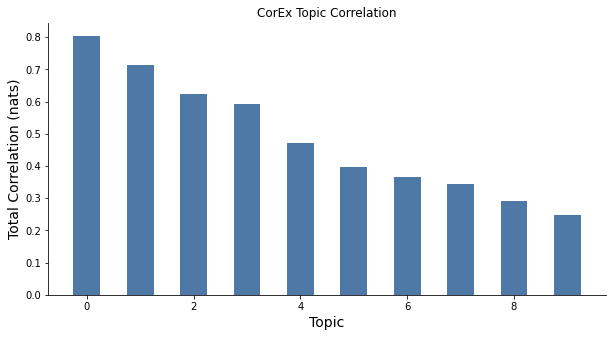

In [34]:
%matplotlib inline
plot_topics(topic_model)

In [35]:
show_top_tweets(topic_model, 5)

Topic 0
1) starkauthor on going viral amp bringing sandy hook las vegas amp parkland shooting survivors together watch here keynotes bullying antibullying schoolshooting confidence empowerment standupnow thecamelproject events bookings dm mjaspeakers
2) in the end the psychopathology of school shooters can be distilled into just two distinguishing factors   youtubeshooting msdstrong newtown schoolshooting kindleunlimited
3) ya est n llegando los seres queridos de alyssa alhadeff de a os de edad a su servicio funebre en north lauderdale es el primero de funerales tras las masacre en la escuela marjory stoneman douglas m s detalles en su noticiero local telemundo al medio d a schoolshooting
4) keynote speakers pgockley starkauthor amp meredith o connor antibullying icon support thecamel project via youtube panelist conference summit women retreat stopbullying bullying womenwholead schoolshooting moms bookings dm mjaspeakers
5) keynote speakers pgockley starkauthor amp meredith o connor a

1) spikes tactical out of apopka fl thinks a bump stock with a setting for libturds is a gem and the ever greasy realalexjones retweets this trash while the news is still coming in about the fl high school shooting disgusting schoolshooting thoughtsandprayers
2) are all these school shootings giving the impression the wrong impression that klids today are just aholes schoolshooting guncontrol
3) pay legit company payessay pay homework pay assignment pay online class pay chemistry pay biology pay history pay research paper pay lab report pay stats pay sociology pay economics pay accounting essayhelp schoolshooting
4) i don t have the words to adequately convey how i feel about today s schoolshooting i m legitimately baffled school shooting of the very young year should make everyone question what is happening in our country stopgunviolencenow
5) the fact that we ve accepted schoolshooting as inevitable is the final nail in our coffin as a civilized country americans have now officially 

## Setting up LDA model to split tweets by topic, assign topic labels according to most common words w/in each topic group, then put similar topics together for further analysis

In [38]:
proc_tweets = tweets.clean

In [39]:
vectorizer = CountVectorizer(token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True,
                             stop_words='english')

In [40]:
dtm_tf = vectorizer.fit_transform(proc_tweets)
print(dtm_tf.shape)

(78973, 59488)


In [42]:
%%time

lda_model = LatentDirichletAllocation(n_components=12, 
                                      random_state=42, 
                                      n_jobs=-1,
                                      max_iter=200
                                     )


lda_model.fit(dtm_tf)

lda_doc_matrix = lda_model.transform(dtm_tf)

Wall time: 8min 34s


In [43]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [48]:
terms = vectorizer.get_feature_names()

display_topics(lda_model, terms, 30)


Topic  0
schoolshooting, school, schools, shooters, schoolsafety, guncontrol, security, mind, safety, shooting, problem, model, texasshooting, inter, implications, understood, shootings, eager, activeshooter, massshooting, minds, check, students, people, education, latest, lockdown, armed, teachers, schoolshootings

Topic  1
schoolshooting, texas, news, santafe, youtube, usa, amp, progress, smh, women, basketball, trump, obama, conference, covid, president, join, dm, bookings, speak, mjaspeakers, tweets, speakers, keynote, education, wtf, starkauthor, biden, summit, kids

Topic  2
schoolshooting, prayers, connecticut, families, thoughts, children, newtown, victims, sad, shooting, heart, today, school, kids, ct, tragedy, dead, amp, praying, elementary, pray, people, goes, affected, god, sandyhook, lost, day, just, news

Topic  3
schoolshooting, safe, kids, school, support, amp, building, group, plot, teenagers, lies, bullies, club, form, revenge, secrets, truths, discovering, shatterin

In [47]:
lda_doc_matrix.shape

(78973, 12)

## This is just my interpretation of the topics according to the results above. This is just a first pass and could be done differently (gun control should probably be in the mix of topics, but since we are primarily concerned with the Sandy Hook and Parkland shootings, assigning all topics perfectly is not as necessary at this step, but could be revisited if further analysis will be done using this as a starting place.)

In [49]:
topic_cols = ['texasshooting', 'general', 'sandyhook_1', 'columbine_1', 'columbine_2', 'sandyhook_2', 'saugushigh', 'parkland_1', 'sandyhook_3', 'parkland_2', 'general_2', 'saugushigh_2']

In [50]:
lda_df = pd.DataFrame(lda_doc_matrix, columns=topic_cols)

In [67]:
lda_df.head()

,texasshooting,general,sandyhook_1,columbine_1,columbine_2,sandyhook_2,saugushigh,parkland_1,sandyhook_3,parkland_2,general_2,saugushigh_2,sandyhook,parkland,columbine
0,0.003623,0.007247,0.182142,0.003623,0.117943,0.003623,0.213279,0.464896,0.003623,0.003623,0.003623,0.003623,0.200258,0.468520,0.125189
1,0.005556,0.141670,0.005556,0.005556,0.608745,0.005556,0.415833,0.005556,0.005556,0.005556,0.005556,0.205138,0.163893,0.011112,0.619857
2,0.084111,0.008772,0.004386,0.004386,0.004386,0.004386,0.951643,0.199003,0.004386,0.208169,0.004386,0.473628,0.026317,0.407171,0.013158
3,0.007576,0.015152,0.007576,0.007576,0.007576,0.007576,1.631694,0.112183,0.007576,0.007576,0.007576,0.812059,0.045455,0.119758,0.022727
4,0.005208,0.010417,0.259255,0.005208,0.005208,0.005208,0.015625,0.005208,0.005208,0.688661,0.005209,0.005208,0.285298,0.693869,0.015625


In [68]:
lda_df['sandyhook'] = lda_df['sandyhook_1'] + lda_df['sandyhook_2'] + lda_df['sandyhook_3']
lda_df['general'] = lda_df['general'] + lda_df['general_2']
lda_df['parkland'] = lda_df['parkland_1'] + lda_df['parkland_2']
lda_df['columbine'] = lda_df['columbine_1'] + lda_df['columbine']
lda_df['saugushigh'] = lda_df['saugushigh'] + lda_df['saugushigh_2']

In [69]:
lda_df.head()

,texasshooting,general,sandyhook_1,columbine_1,columbine_2,sandyhook_2,saugushigh,parkland_1,sandyhook_3,parkland_2,general_2,saugushigh_2,sandyhook,parkland,columbine
0,0.003623,0.010870,0.182142,0.003623,0.117943,0.003623,0.216903,0.464896,0.003623,0.003623,0.003623,0.003623,0.189388,0.468520,0.128813
1,0.005556,0.147226,0.005556,0.005556,0.608745,0.005556,0.620971,0.005556,0.005556,0.005556,0.005556,0.205138,0.016667,0.011112,0.625413
2,0.084111,0.013159,0.004386,0.004386,0.004386,0.004386,1.425271,0.199003,0.004386,0.208169,0.004386,0.473628,0.013158,0.407171,0.017545
3,0.007576,0.022727,0.007576,0.007576,0.007576,0.007576,2.443753,0.112183,0.007576,0.007576,0.007576,0.812059,0.022728,0.119758,0.030303
4,0.005208,0.015626,0.259255,0.005208,0.005208,0.005208,0.020833,0.005208,0.005208,0.688661,0.005209,0.005208,0.269672,0.693869,0.020833


In [70]:
topic_df = lda_df[['sandyhook', 'parkland', 'columbine', 'general', 'saugushigh']]

In [71]:
topic_df['label'] = topic_df.idxmax(axis=1)

In [72]:
topic_df.head()

,sandyhook,parkland,columbine,general,saugushigh,label
0,0.189388,0.468520,0.128813,0.010870,0.216903,parkland
1,0.016667,0.011112,0.625413,0.147226,0.620971,columbine
2,0.013158,0.407171,0.017545,0.013159,1.425271,saugushigh
3,0.022728,0.119758,0.030303,0.022727,2.443753,saugushigh
4,0.269672,0.693869,0.020833,0.015626,0.020833,parkland


## Now that we have assigned topic labels according to the LDA vectors, we can add back in the text, date, and username of each of the tweets

In [77]:
topic_df['tweet'] = tweets.clean
topic_df['date'] = df.date
topic_df['username'] = df.username

In [78]:
topic_df.head()

,sandyhook,parkland,columbine,general,saugushigh,label,tweet,date,username
0,0.189388,0.468520,0.128813,0.010870,0.216903,parkland,florida gov ordered a moment of silence at p m...,2021-02-13,k12ssdb
1,0.016667,0.011112,0.625413,0.147226,0.620971,columbine,threats of school violence appeared to increas...,2021-02-13,k12ssdb
2,0.013158,0.407171,0.017545,0.013159,1.425271,saugushigh,a year old man is expected to make a full reco...,2021-02-13,k12ssdb
3,0.022728,0.119758,0.030303,0.022727,2.443753,saugushigh,police found a fatally shot near a back parkin...,2021-02-13,k12ssdb
4,0.269672,0.693869,0.020833,0.015626,0.020833,parkland,senrickscott marcorubio words on the senate fl...,2021-02-12,mrsgreenberg


## Visualizing the topic frequency according to tweet count

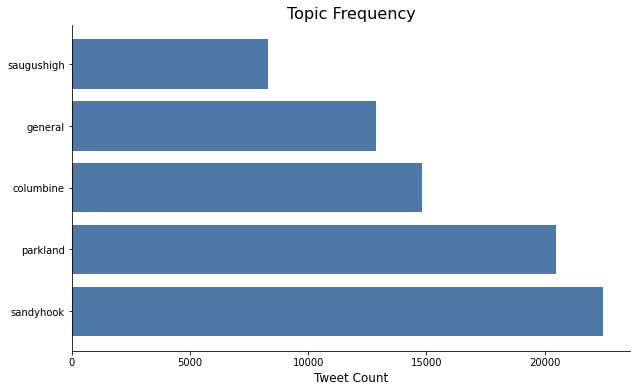

In [94]:
labels = ['sandyhook', 'parkland', 'columbine', 'general', 'saugushigh']

top_freq = list(topic_df['label'].value_counts())

plt.figure(figsize=(10, 6))
plt.barh(labels, top_freq, color='#4e79a7')
plt.xlabel('Tweet Count', fontsize=12)
plt.title("Topic Frequency", fontsize=16)
sns.despine()
plt.savefig(r'../topic_frequency.png');

## Next we will visualize the tweet topics over time

In [80]:
date_freq = topic_df.groupby(['date', 'label']).size().unstack().reset_index()

In [81]:
date_freq.fillna(0, inplace=True)
date_freq['total'] = date_freq.sum(axis=1)

In [82]:
date_freq

label,date,columbine,general,parkland,sandyhook,saugushigh,total
0,2009-03-11,0.0,3.0,0.0,0.0,2.0,5.0
1,2009-03-12,0.0,0.0,0.0,0.0,1.0,1.0
2,2009-03-17,1.0,0.0,0.0,0.0,0.0,1.0
3,2009-04-10,0.0,0.0,0.0,0.0,1.0,1.0
4,2009-04-30,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...
2735,2021-02-09,0.0,0.0,2.0,1.0,4.0,7.0
2736,2021-02-10,0.0,1.0,3.0,1.0,5.0,10.0
2737,2021-02-11,0.0,0.0,2.0,0.0,5.0,7.0
2738,2021-02-12,0.0,0.0,2.0,0.0,3.0,5.0


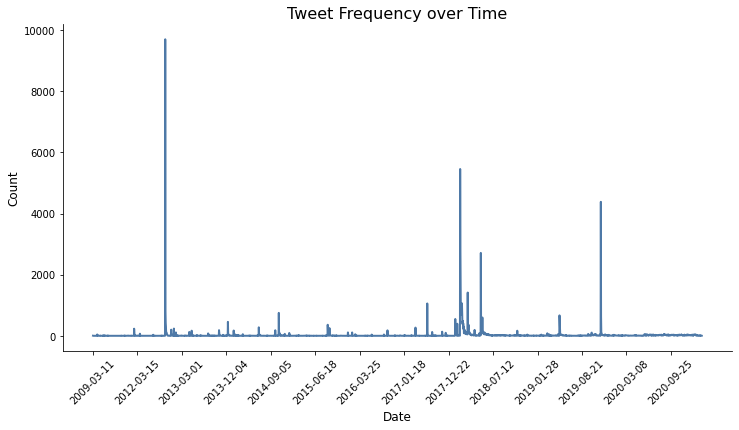

In [99]:
dates = date_freq.date
total_tweets = date_freq.total
x_ticks = list(date_freq.date.unique()[::200])

plt.figure(figsize=(12, 6))
plt.plot(dates, total_tweets, color='#4e79a7', linewidth=2)
plt.title('Tweet Frequency over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(x_ticks, rotation=45)
sns.despine();

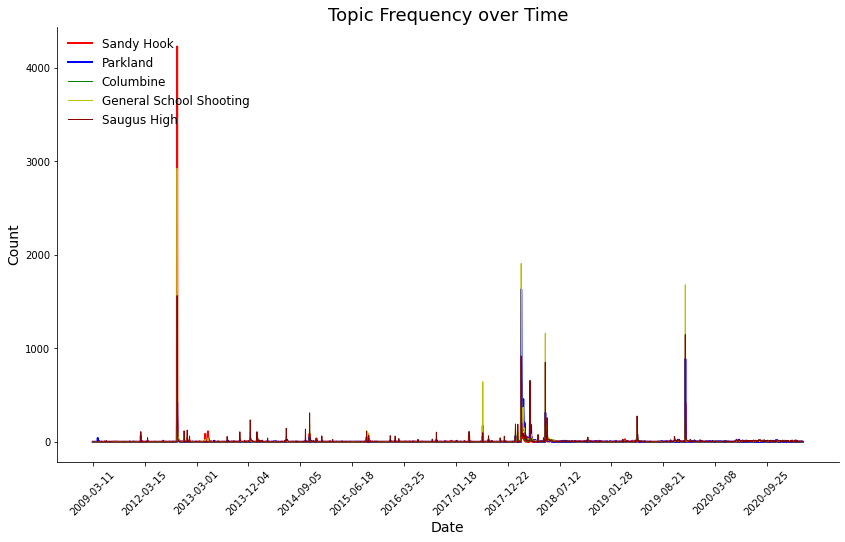

In [97]:
dates_limited = date_freq.date
x_ticks = list(date_freq.date.unique()[::200])

sandyhook = date_freq.sandyhook
parkland = date_freq.parkland
columbine = date_freq.columbine
gen_twitter = date_freq.general
saugushigh = date_freq.saugushigh


plt.figure(figsize=(14, 8))
plt.plot(dates, sandyhook, color='r', linewidth=2, label='Sandy Hook')
plt.plot(dates, parkland, color='b', linewidth=2, label='Parkland')

plt.plot(dates, columbine, color='g', linewidth=1, label='Columbine')
plt.plot(dates, gen_twitter, color='y', linewidth=1, label='General School Shooting')
plt.plot(dates, saugushigh, color='darkred', linewidth=1, label='Saugus High')


plt.title('Topic Frequency over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(x_ticks, rotation=45)
plt.legend(loc='upper left', frameon=False, fontsize=12)
sns.despine()

## There is obviously still plenty to explore - the spikes shown in the previous two visualizations are assumed to correlate with new shootings occurring, but a further exploration of dates, zooming in on the spikes, might show more interesting patterns. 

## Note - the "date" field is not in datetime format and will need to be modified before date operations could be used

## A sentiment analysis would also be a good next step, as well as an exploration of how more preprocessing steps (searching for and removing bot accounts, addressing hashtags, etc) might change the patterns seen so far.